# NaMaster tutorial

If NaMaster is correclty installed the following import statements should run smoothly.  

In [1]:
import os.path as op
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
import warnings

Let's load now the theory (lensed CMB) spectra from CAMB. We choose r=0. The file is the same used in the QML estimation of course.

In [2]:
CURRENT_PATH = op.abspath('')
cls_file = CURRENT_PATH+'/ancillary_files/Cls_no_tensor_tutorial.npy'

#load input model
clth = np.load(cls_file)

We will work with maps at $N_{\rm side}=64$ 

In [3]:
nside = 64
LMIN = 2 
LMAX = 3*nside 

In [4]:
ell = np.arange(LMIN, LMAX+2)

We compute now the pixel variance and establish a noise level (10 muK-arcmin) 

In [5]:
def Karcmin2var(Karcmin, nside):
    """
    Return pixel variance for a given nside and noise level [K . arcmin]

    Parameters
    ----------
    Karcmin : float
        Pixel noise [K . arcmin]
    nside : int
        Healpix map resolution (power of 2)

    Returns
    ----------
    varperpix : float
        Variance per pixel
    """
    pixarea = hp.nside2pixarea(nside, degrees=True)
    varperpix = (Karcmin / 60.)**2 / pixarea
    return varperpix


muKarcmin = 10.
pixvar = Karcmin2var(muKarcmin, nside)


We can now prepare the mask: choose an apodization scale and $f_{sky}$ (you should try many different apodization scales and $f_{sky}$ find the one that minimizes the variance at each ell, while not biasing results too much because of foregrounds contamination...see slides).

Downgrading of the mask in pixel space is again performed in two steps since healpy cannot handle it in one step.

In [6]:
apo_scale = 10.  # apodization scale in degrees
apo_type = 'C2'  # apodization method
mask_kind = 'PL' # planck or litebird masks
planck_field = 2 # f_sky = 20, 40, 60, 70, 80, 90, 97, 99% starting from 0

    
planck_mask = hp.read_map(CURRENT_PATH+'/ancillary_files/HFI_Mask_GalPlane-apo0_2048_R2.00.fits', field=planck_field)
planck_mask = hp.ud_grade(planck_mask, nside_out=256)
planck_mask = nmt.mask_apodization(planck_mask, apo_scale, apotype=apo_type)
planck_mask = hp.ud_grade(planck_mask, nside_out=nside)
mask = planck_mask

fsky = np.mean(mask)
print("f_sky =", fsky)


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/global/homes/p/pcampeti/.conda/envs/tutorial/lib/python3.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
f_sky = 0.5152931033966728


/global/homes/p/pcampeti/.conda/envs/tutorial/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/global/homes/p/pcampeti/.conda/envs/tutorial/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


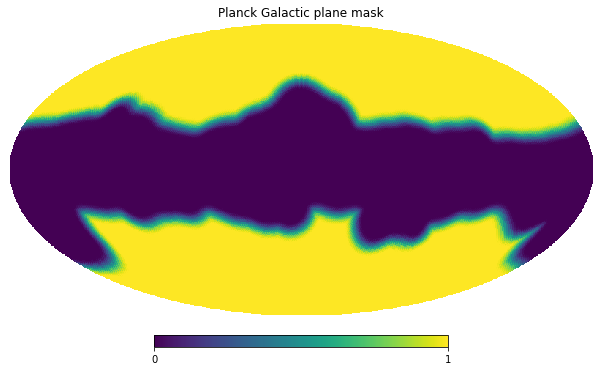

In [7]:
hp.mollview(mask, title='Planck Galactic plane mask')

Standard function defined for NaMaster 

In [8]:
def compute_master(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_decoupled


Convolve theoretical CMB with beam, define binning scheme and define some relevant parameters

In [9]:
# create Gaussian 80 arcmin beam    
beam = 80 # in arcmin
fwhm_beam = beam*np.pi/(180*60) # beam in radians

beam_alm = hp.sphtfunc.gauss_beam(fwhm=fwhm_beam, lmax=LMAX, pol=True)

beam_T_unb = beam_alm[:LMAX,0]
beam_E_unb = beam_alm[:LMAX,1]
beam_B_unb = beam_alm[:LMAX,2]

ClTT_lensed = clth[0][:LMAX]*beam_T_unb**2
ClEE_lensed = clth[1][:LMAX]*beam_E_unb**2
ClBB_lensed = clth[2][:LMAX]*beam_B_unb**2
ClTE_lensed = clth[3][:LMAX]*beam_T_unb*beam_E_unb

Cls_in = [ClTT_lensed, ClEE_lensed,  ClBB_lensed, ClTE_lensed]

num_samples = 1000

# define binning scheme
bins_number = 45 # total number of bins (first 35 multipoles are unbinned, then binned every 10 multipoles)
Cls_out_EE = np.zeros((num_samples, bins_number))
Cls_out_BB = np.zeros((num_samples, bins_number))

# left edeges if the bins
l0 = np.array([2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  46,  56,  66,  76,
        86,  96, 106, 116, 126, 136])

# right edges of the bins
lf = np.array([3,   4,   5,   6,   7,   8,   9,   10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  46,  56,  66,  76,  86,
        96, 106, 116, 126, 136, 146])

width = 10 # delta-ell of the binned part
data = beam_B_unb[36:150]
# bin the beam for deconvolution later 
result = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)
beam_B = np.concatenate((beam_B_unb[LMIN:36], result), axis=0)

nstoke = 2 # Q, U 
npix = np.int(sum(mask))
npixtot = len(mask)


Let's do now our MC analysis, estimating pseudo-Cls spectra for each of the 1000 Gaussian maps realizations of CMB + noise   

We then deconvolve the beam from the estimated spectra

In [10]:
for i in range(num_samples):
    print('Simulation # ', i)
    seed = i
    np.random.seed(seed)
    T_map, Q_map, U_map = hp.synfast(Cls_in, nside=nside, pol=True, new=True)
    noise_map = np.random.randn(nstoke, npixtot) * np.sqrt(pixvar)
    Q_map = noise_map[0] + Q_map
    U_map = noise_map[1] + U_map
        
    f_2 = nmt.NmtField(mask, [Q_map, U_map], purify_b=False) 
    b = nmt.NmtBin.from_edges(l0, lf)      
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f_2, f_2, b)    
    cl_22 = compute_master(f_2, f_2, w)
    Cls_out_EE[i] = cl_22[0]
    Cls_out_BB[i] = cl_22[3] 

# subtract bad simulations
num_samples = num_samples - 2

# deconvolve beams
Cls_out_BB = Cls_out_BB/(beam_B**2)    
    
# compute mean of the sims
sim_mean = np.sum(Cls_out_BB, axis=0)/num_samples    


Simulation #  0
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  1
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  2
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  3
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  4
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  5
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  6
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  7
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  8
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  9
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  10
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Simulation #  11
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.0000

We now save the pseudo-cls files in a .npy file. Note that the name contains a few info on the procedure used to estimate the spectrum.

In [11]:
np.save('Pseudocls_whitenoise_apo'+str(apo_scale)+'_'+apo_type+'_'+mask_kind+'_fsky_'+str(fsky)+
        '_binned.npy', Cls_out_BB)    


In [12]:
ell_arr = b.get_effective_ells()


We define a function to compute white noise expectated spectrum to use in the plot for comparison. 

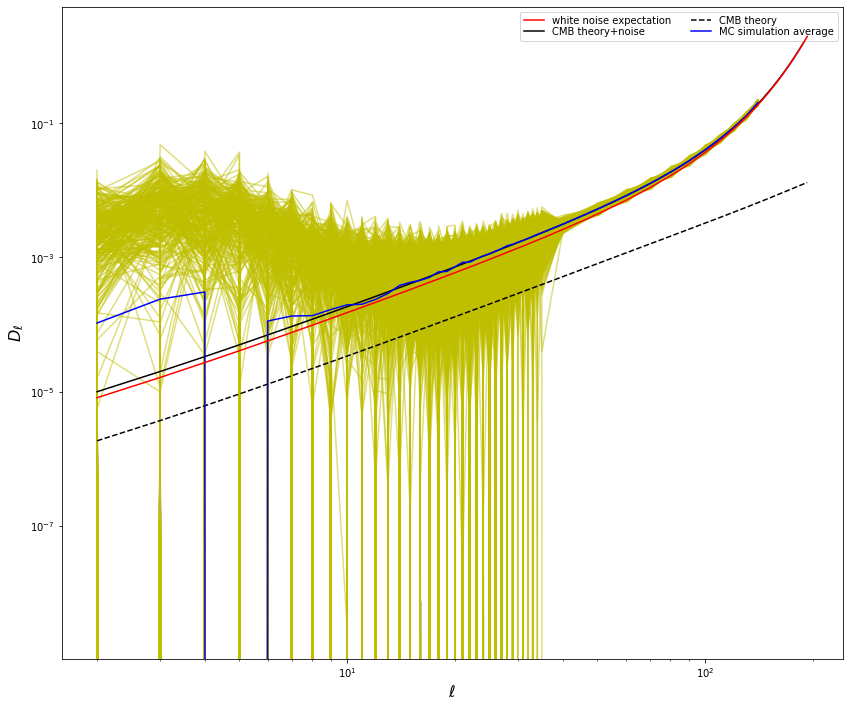

In [13]:
def Nell(depth_p, fwhm, lmax):  
    '''
    fwhm in arcmin.
    '''
    bl = hp.gauss_beam(np.radians(fwhm/60.), lmax=lmax+1, pol=True)[:,2] 
    nl = (np.radians(depth_p/60.) / np.array(bl))**2 
    return nl[2:]

toDl_arr = ell_arr*(ell_arr+1)/2./np.pi
toDl = ell*(ell+1)/2./np.pi


fig = plt.figure(figsize=(14,12), facecolor='w', edgecolor='k')
ax = plt.gca()
for i in range(num_samples):
    plt.plot(ell_arr, toDl_arr*Cls_out_BB[i], 'y-', alpha=0.5)
plt.plot(ell, toDl*Nell(muKarcmin, beam, LMAX), color='red', zorder=100, label='white noise expectation')
plt.plot(ell, toDl*(clth[2][2:LMAX+2] + Nell(muKarcmin, beam, LMAX)), linestyle='-', color='black', label='CMB theory+noise')
plt.plot(ell, toDl*clth[2][2:LMAX+2], label='CMB theory', linestyle='--', color='black')
plt.plot(ell_arr, toDl_arr*sim_mean, color='blue', label='MC simulation average')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$D_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.savefig('NaMaster_pseudo_cl.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
